In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import mpld3
import pandas as pd
import imp
import numpy as np
import os
from sqlalchemy import create_engine
from IPython.display import Image
sn.set_context('notebook')

# RID loads estimation

The [exploratory notebook](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/rid_data_exploration.ipynb) documented initial code for estimating loads and also demonstrated that the results are comparable to those reported previously. This notebook develops the code further and applies it more generally to produce standard plots for the report.

In [2]:
# Connect to db
resa2_basic_path = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\Upload_Template'
                    r'\useful_resa2_code.py')
resa2_basic = imp.load_source('useful_resa2_code', resa2_basic_path)
engine, conn = resa2_basic.connect_to_resa2()

# Import custom RID functions
rid_func_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
                 r'\Python\rid\notebooks\useful_rid_code.py')
rid = imp.load_source('useful_rid_code', rid_func_path)

In [3]:
# Read site data
in_xlsx = r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\Data\RID_Sites_List.xlsx'

rid_11_df = pd.read_excel(in_xlsx, sheetname='RID_11')
rid_36_df = pd.read_excel(in_xlsx, sheetname='RID_36')
rid_108_df = pd.read_excel(in_xlsx, sheetname='RID_108')

# Drop the 37th site (with no NVE code) from RID_36
rid_36_df.dropna(how='any', inplace=True)

## 1. Load estimation workflow

The basic approach to estimating loads is documented in the [exploratory notebook](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/rid_data_exploration.ipynb). However, a number of further modifications are required to make the workflow here compatible with what has been done previously. 

My initial code focused on estimating loads only where observations are available, and the output compares favourably to the values presented on pages 117 to 142 of the 2015 report. However, there are some important differences - most notably, some of the published plots include "*extra or interpolated*" loads. In most cases, we do not have data in RESA2 for these years, so they have clearly been estimated using an alternative method. Strangely, though, in some cases we **do** have data for these years, but these data have not been used in the loads calculations (see e.g. Hg from 1999 to 2003 at site 29615). **Need to check why estimated rather than measured values have been used here**. 

Looking at RESA2, it seems as though most of Tore's code for interpolation and patching is located in the procedures `CALCULATE_RID_STATISTICS`, `FIXNON109` and `FIX_NEGATIVE_VALUES`. As far as I can tell, when there are no water chemistry observations for a particular parameter in the specified year, values are inferred using the following workflow:

 1. Data for all years between 1990 and the present day are extracted for the parameter of interest and the **average concentration in each year** is calculated. <br><br>
 
 2. The **Theil-Sen estimator** is used to fit a simple linear regression line to the observed annual averages. <br><br>
 
 3. Values are inferred in two ways:
    
    i. For **interpolation** of missing data (i.e. the missing years have measured data *both before and after*), the fitted regression line is used to estimate the annual concentration in the year of interest. 
    
    ii. For **extrapolation** of missing data (i.e. estimating values *before the start or after the end* of the observed series), the fitted regression line is used to estimate the concentration for the first or last year in the observed series, and this value is assumed to remain constant for all previous or later years, respectively. Note that this approach is especially relevant for the RID_108 rivers, where fluxes post-2003 have been estimated by first using a regression line to calculate 2003 concentrations, and then forward-filling.
    
    In all cases, inferred concentrations are assigned to June 30th (i.e. the middle of the year), and loads are then estimated using the standard OSPAR methodology. 
    
This approach seems over-complicated given the errors involved, and I'm not sure it's really justified. Either a dataset exhibits a linear trend, in which case regression can be used for both interpolation and extrapolation, or it does not, in which case linear regression is inappropriate. Using regression to estimate concentrations for e.g. 2003 and then forward-filling seems unnecessary, because we already have measured data for these sites from 2003. A simpler and more defensible approach in my opinion would be to forward-fill from either the median of the whole series or the last measured value (and, similarly, we could backward-fill from either median or the first measured value). Regardless, I'm not sure it's actually meaningful to report e.g. 2016 loads when the last measured chemistry values are from 2003.

Nevertheless, in order to maintain compatibility with previous analyses, I have added a function to my loads estimation code that implements more-or-less this workflow. The `estimate_loads` function can now be called using the option `infer_missing=True`, in which case loads are inferred for years even when no observations are available. My approach broadly follows the steps outlined above, but note the following:

 * Sen's slope can only be used if the number of years with data is greater than 2 (and the results aren't very meaningful until there are substantially more data points than this). If two or fewer years of data are available, the median is used for both interpolation and extrapolation. <br><br>
 
 * The Sen's slope equation is only used if the estimated slope is significantly different from zero at p < 0.05. Otherwise, the median of the series is used instead. <br><br>

**Note 1:** When I first wrote my function for calculating loads, I had not anticipated this part of the workflow. My code is therefore inefficient for these calculations, because there's a substantial overhead in the repeated calls being made to the database. Using `infer_missing=True` therefore causes a significant slow-down - **use with caution**. If this functionality is desirable, it should be straightforward to refactor the code to make it faster, but I have not looked at this yet.

**Note 2:** In Tore's RESA2 workflow, most of the relevant data - both observed and interpolated - is written to the tables `RESA2.RID_TIMESERIES` and `RIS_TIMESERIES_STATISTICS`. The `ESTIMATED` column in the former specifies whether the value is observed or estimated (by regression), whereas the `ESTIMATE_TYPE` column specifies how LOD values have been handled (0 = "lower estimate"; 1 = "upper estimate"; 2 = "OSPAR estimate").

## 2. Loads for all rivers for the current year

### 2.1. Estimate loads

Loads for the RID_11 and RID_36 rivers for 2015 were calculated in the [first notebook](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/rid_data_exploration.ipynb) (using `infer_missing=False`). 

Pages 186 to 195 of the report tabulate 2015 load estimates for all 155 main rivers in the RID programme (i.e. including the RID_108 rivers, which haven't been monitored for water chemistry since 2003). In the code below, loads are estimated for all 155 rivers using `infer_missing=True`.

In [4]:
# Sites of interest: combine all site dfs into one
rid_all_df = pd.concat([rid_11_df, rid_36_df, rid_108_df], axis=0)

# Pars of interest
par_list = ['SPM', 'TOC', 'PO4-P', 'TOTP', 'NO3-N', 'NH4-N', 
            'TOTN', 'SiO2', 'Ag', 'As', 'Pb', 'Cd', 'Cu', 
            'Zn', 'Ni', 'Cr', 'Hg']

# Year of interest
year = 2015

# Container for results from each site
loads_list = []

# Loop over sites
for stn_id in rid_all_df['station_id'].values:
    # Estimate loads at this site
    loads_list.append(rid.estimate_loads(stn_id, par_list, 
                                         year, engine,
                                         infer_missing=True))

# Concatenate to new df
lds_all = pd.concat(loads_list, axis=0)

# Save output
out_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Results\Loads_CSVs\loads_all_sites_%s.csv' % year)
lds_all.to_csv(out_csv, index_label='station_id')

    WARNING
    The database contains duplicated values for some station-date-parameter combinations.
    Only the most recent values will be used, but you should check the repeated values are not errors.
    The duplicated entries are returned in a separate dataframe.

    WARNING
    The database contains duplicated values for some station-date-parameter combinations.
    Only the most recent values will be used, but you should check the repeated values are not errors.
    The duplicated entries are returned in a separate dataframe.

    WARNING
    The database contains duplicated values for some station-date-parameter combinations.
    Only the most recent values will be used, but you should check the repeated values are not errors.
    The duplicated entries are returned in a separate dataframe.

    WARNING
    The database contains duplicated values for some station-date-parameter combinations.
    Only the most recent values will be used, but you should check the repeated value

In [5]:
lds_all.head()

,Ag_Est,Ag_tonnes,As_Est,As_tonnes,Cd_Est,Cd_tonnes,Cr_Est,Cr_tonnes,Cu_Est,Cu_tonnes,...,SiO2_Est,SiO2_tonnes,TOC_Est,TOC_tonnes,TOTN_Est,TOTN_tonnes,TOTP_Est,TOTP_tonnes,Zn_Est,Zn_tonnes
29615,0.0,0.026539,0,0.857952,0,0.061313,0,0.756944,0,3.331996,...,0,15400.645238,0,19769.002563,0,1835.821707,0,54.316502,0,14.103754
29821,0.0,0.002314,0,0.306379,0,0.023318,0,0.226911,0,1.329618,...,0,3884.195547,0,4250.520442,0,753.897822,0,14.157888,0,4.630855
29783,0.0,0.000313,0,0.053425,0,0.002838,0,0.036453,0,0.396587,...,0,402.486799,0,1104.348470,0,358.968888,0,12.490117,0,0.813640
29613,0.0,0.004396,0,1.222710,0,0.098260,0,0.848039,0,4.699313,...,0,24127.955126,0,32484.541692,0,2919.198125,0,37.289778,0,32.453892
29614,0.0,0.017286,0,0.711897,0,0.099588,0,0.518189,0,2.802546,...,0,9511.041660,0,18142.603061,0,1354.405790,0,17.226651,0,18.501505


### 2.2. Compare to previous results

I have copied the data table from pages 186 to 195 of the report to Excel here:

C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\Report\Loads_2015_All_Rivers.xlsx

This can be used to compare the output from my new code to the previously published results.

**Note:** there seem to be some issues with the data in the 2015 report. Under the heading `TRIBUTARY RIVERS (108)` there are actually 162 rows - many of the RID_108 rivers seem to be duplicated. What's more, the table only provides the river names (not the codes or the station IDs) and the the river names in this project are **not unique**:

 * Børselva could be station ID 30027 (FINEBØR) or station ID 30112 (STREBØR) <br><br>
 
 * Oselva could be station ID 30049 (HOREOSL) or station ID 30106 (SFJEOSE)
 
Finally, some of the loads in the published table are **negative** (see e.g. the River Eira for SPM, where the load is reported as -804 tonnes in 2015). Presumably this is due to "over-extrapolation" when using regression lines to predict unmonitored values?

For the comparison below, I have **guessed the assignment of the two ambiguous stations** and then dropped the duplicated rows. I have left the negative values unchanged as they are obvious on the plots below, but clearly loads cannot be negative.

In [6]:
# Read data from 2015 report
in_xlsx = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Report\Loads_2015_All_Rivers.xlsx')
old_df = pd.read_excel(in_xlsx, sheetname='Sheet1')

# Drop duplicates
old_df.drop_duplicates(inplace=True)

print len(old_df)

old_df.head()

155


,station_id,station_code,station_name,Estimate,Q_m3/d,SPM_tonnes,TOC_tonnes,PO4-P_tonnes,TOTP_tonnes,NO3-N_tonnes,...,SiO2_tonnes,Ag_tonnes,As_tonnes,Pb_tonnes,Cd_tonnes,Cu_tonnes,Zn_tonnes,Ni_tonnes,Cr_tonnes,Hg_kg
0,29617,ØSTEGLO,Glomma ved Sarpsfoss,avg.,69849,295151,115805,291,499,8706,...,103992,0.092,4.993,7.918,0.308,40.799,245.827,21.145,8.282,19.002
1,36225,OSLEALN,Alna,avg.,158,1228,280,4,5,47,...,424,0.000,0.025,0.120,0.005,0.288,1.186,0.070,0.042,0.060
2,29612,BUSEDRA,Drammenselva,avg.,31414,75313,48045,80,140,2724,...,39256,0.012,2.266,6.101,0.139,12.633,47.217,7.046,2.564,9.739
3,29615,VESENUM,Numedalslågen,avg.,11286,36586,19767,30,54,809,...,15401,0.027,0.858,1.286,0.061,3.332,14.104,1.678,0.757,6.887
4,29613,TELESKI,Skienselva,avg.,30346,10151,32483,12,37,1322,...,24128,0.004,1.223,0.933,0.098,4.699,32.443,2.024,0.848,10.562


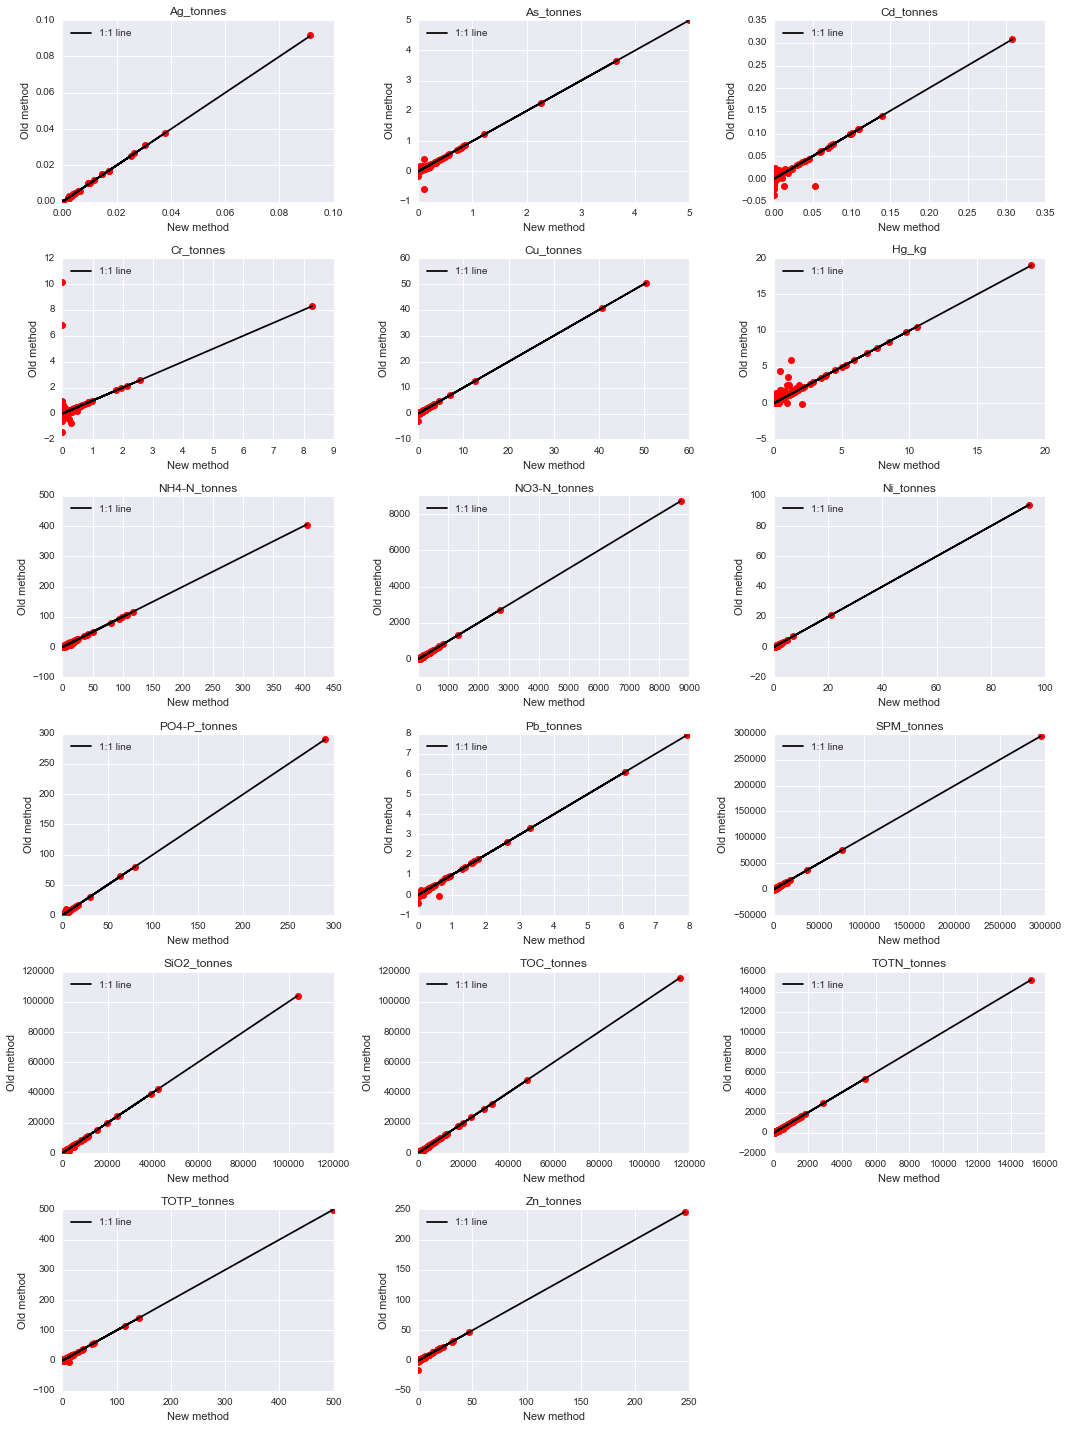

In [7]:
# Ignore "_Est" cols in new output
val_cols = [i for i in lds_all.columns if i.split('_')[1]!='Est']    
new_df = lds_all[val_cols]
   
# Set index on published data
old_df.index = old_df['station_id']

# Merge
df = pd.merge(old_df, new_df, how='left',
              left_index=True, right_index=True,
              suffixes=['_old', '_new'])

# Scatterplots
fig, axes = plt.subplots(nrows=6, ncols=3,
                         sharey=False, sharex=False,
                         figsize=(15,20))
axes = axes.flatten()

# Loop over plots
for idx, par in enumerate(new_df.columns):
    axes[idx].plot(df[par+'_new'], df[par+'_old'], 'ro', label='')
    axes[idx].plot(df[par+'_new'], df[par+'_new'], 'k-', label='1:1 line')
    axes[idx].set_xlabel('New method')
    axes[idx].set_ylabel('Old method')
    axes[idx].set_title(par)
    axes[idx].legend(loc='upper left')

# Tidy
fig.delaxes(axes[-1])
plt.tight_layout()

The plots above can be compared to those at the end of the [exploratory notebook](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/rid_data_exploration.ipynb). Those in the previous notebook show results for just the RID_11 and RID_36 sites (based only on observed values), whereas the ones above include estimates for the RID_108 stations as well.

Overall, the vast majority of points are on (or very close to) the 1:1 line, which is good. The only significant departures are for a few of the RID_108 stations for parameters that are often at or below the detection limit (mainly As, Cd, Cr and Hg). My method of dealing with detection limit values is consistent with the OSPAR methodology, but when it comes to estimating values for years with missing data there are some differences between Tore's approach and mine. As far as I can tell, Tore's code estimates the "OSPAR regression line" as follows:

 1. Estimate an "upper" regression line (slope and intercept) by assuming all LOD values are equal to the LOD and applying Sen's method to the average annual concentration data <br><br>
 
 2. Estimate a "lower" regression line in the same way, but this time assuming that all LOD values are zero <br><br>
 
 3. Estimate the "OSPAR" regression line by averaging the "upper" and "lower" slopes and intercepts calculated above

In contrast, my code currently extracts all the data from the database for the site and parameter of interest and then adjusts any LOD values according to the OSPAR methodology (see section 2.3.2 of [this notebook](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/rid_data_exploration.ipynb) for details). I then calculate annual averages and apply the Sen's slope method *once* to estimate a single slope and intercept. 

In cases where a large proportion of the measured values are at or below the detection limit, these two approaches can yield substantially different regression coefficients, and I suspect this is the explanation for most of the differences on the plots above.

If the negative values in the published report are all assumed to be zero, then the only real differences between the new output and the old values are (i) diagreements in loads for many of the RID_108 Hg values and (ii) two very obvious outliers on the plot for Cr. The time series for Hg include lots of LOD values and so, based on the discussion above, it is not surprising that these results are different. The two outliers for Cr, however, seem especially obvious and are worth investigating further.

In [8]:
# Get just the data for Cr
val_cols = [i for i in df.columns if i.split('_')[0]=='Cr']    
df_cr = df[val_cols]

# Identify "outlier stations"
df_cr.query('(Cr_tonnes_new == 0) and (Cr_tonnes_old > 6)')

,Cr_tonnes_old,Cr_tonnes_new
station_id,,
30070,6.819,0.0
30072,10.182,0.0


Looking at the data in RESA2, the differences between estimates for these two sites are just particularly extreme examples of the contrast between the two regression approaches described above: Tore's approach estimates an insignificnat slope, whereas mine estimates a significnat decreasing trend and predicts concentrations close to zero by 2003.

Overall, I don't think any of these discrepancies are cause for concern.

## 3. Loads for RID_11 rivers through time

Pages 117 to 142 of the 2015 report show bar charts of loads through time for 10 of the RID_11 rivers. The code below first estimates loads for these sites for the period from 1990 to 2015 (also using `infer_missing=True`).

In [9]:
# Period of interest
st_yr, end_yr = 1990, 2015

# Container for results 
loads_list = []

# Loop over sites
for stn_id in rid_11_df['station_id'].values:
    # Loop over years
    for year in range(st_yr, end_yr+1):
        print 'Processing Station ID %s for %s' % (stn_id, year)
        
        # Get loads
        l_df = rid.estimate_loads(stn_id, par_list, 
                                  year, engine,
                                  infer_missing=True)
        
        if l_df is not None:
            # Name and reset index
            l_df.index.name = 'station_id'
            l_df.reset_index(inplace=True)

            # Add year
            l_df['year'] = year

            # Add to outout
            loads_list.append(l_df)

# Concatenate to new df
lds_ts = pd.concat(loads_list, axis=0)

# Build multi-index
lds_ts.set_index(['station_id', 'year'], inplace=True)

# Save output
out_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Results\Loads_CSVs\loads_ts_11_%s-%s.csv' % (st_yr, end_yr))
lds_ts.to_csv(out_csv)

Processing Station ID 29615 for 1990
    WARNING
    The database contains duplicated values for some station-date-parameter combinations.
    Only the most recent values will be used, but you should check the repeated values are not errors.
    The duplicated entries are returned in a separate dataframe.

Processing Station ID 29615 for 1991
    WARNING
    The database contains duplicated values for some station-date-parameter combinations.
    Only the most recent values will be used, but you should check the repeated values are not errors.
    The duplicated entries are returned in a separate dataframe.

Processing Station ID 29615 for 1992
    WARNING
    The database contains duplicated values for some station-date-parameter combinations.
    Only the most recent values will be used, but you should check the repeated values are not errors.
    The duplicated entries are returned in a separate dataframe.

Processing Station ID 29615 for 1993
Processing Station ID 29615 for 1994
  

In [10]:
lds_ts.head(10)

Ag_Est  Ag_tonnes  As_Est  As_tonnes  Cd_Est  Cd_tonnes  \
station_id year                                                            
29615      1990       1   0.085938       1   0.683296       0   0.228425   
           1991       1   0.066964       1   0.532427       0   0.100417   
           1992       1   0.066751       1   0.530737       0   0.627963   
           1993       1   0.083801       0   0.719119       0   0.234133   
           1994       1   0.091918       1   0.730843       0   0.177071   
           1995       1   0.091895       0   1.184851       0   0.418045   
           1996       1   0.060598       0   0.000000       0   0.060655   
           1997       1   0.065014       0   0.310555       0   0.050953   
           1998       1   0.088375       0   0.531750       0   0.147876   
           1999       1   0.090974       0   0.804637       0   0.069576   

                 Cr_Est  Cr_tonnes  Cu_Est  Cu_tonnes     ...      SiO2_Est  \
station_id year                                           ...                 
29615      1990       1   1.392908       0   6.191198     ...             1   
           1991       1   1.085360       0   5.235714     ...             1   
           1992       0   2.777596       0   9.217833     ...             1   
           1993       0   2.139408       0  38.853526     ...             1   
           1994       1   1.403278       0   3.982295     ...             1   
           1995       0   0.000000       0   5.224206     ...             0   
           1996       0   0.000000       0   2.981972     ...             0   
           1997       0   0.727469       0   5.275883     ...             0   
           1998       0   0.000000       0   7.417695     ...             0   
           1999       0   1.059404       0   4.286355     ...             0   

                  SiO2_tonnes  TOC_Est    TOC_tonnes  TOTN_Est  TOTN_tonnes  \
station_id year                                                               
29615      1990  10787.870848        1  13994.152538         0  1235.212106   
           1991   8405.961819        0   8297.922390         0  1105.169503   
           1992   8379.277436        0  12336.054953         0  1409.367745   
           1993  10519.614504        0  15487.080312         0  1586.323638   
           1994  11538.539445        1  15228.781051         0  1724.631323   
           1995   9980.839783        0  13428.309998         0  1463.619114   
           1996   5991.492004        0   8855.011272         0  1163.488334   
           1997   8408.185983        0   9500.268474         0  1309.980967   
           1998  11019.639923        0  12913.920766         0  1634.152956   
           1999  12424.831263        0  17291.900603         0  1739.756341   

                 TOTP_Est  TOTP_tonnes  Zn_Est   Zn_tonnes  
station_id year                                             
29615      1990         0    39.700336       0   23.761415  
           1991         0    33.353097       0   29.034573  
           1992         0    23.337892       0   20.509088  
           1993         0    52.173714       0  147.432082  
           1994         0    33.284365       0   23.101107  
           1995         0    44.514876       0   23.457869  
           1996         0    28.983081       0   11.045798  
           1997         0    33.097835       0   15.416404  
           1998         0    42.739763       0   36.934737  
           1999         1    40.565401       0   21.370341  

[10 rows x 34 columns]

This dataframe can then be used to create point or bar plots, similar to those in the report. For now, my code produces one set of charts per site, rather than grouping by parameter as in the report, but this can easily be changed. 

As in the report, green bars represent estimates based on regression relationships, whereas blue bars are based directly on observational data.

In [11]:
%%capture
# This code cell produces lots of Deprecation Warnings from Seaborn/Pandas.
# %%capture suppresses all output from this cell to keep things tidy

# Output folder for plots
out_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\Results\TS_Plots')

# Loop over df
for stn_id in rid_11_df['station_id'].values:
    # Get data for this station
    df = lds_ts.ix[stn_id]
    
    # Separate est and val cols to two dfs
    cols = df.columns
    est_cols = [i for i in cols if i.split('_')[1]=='Est']
    val_cols = [i for i in cols if i.split('_')[1]!='Est']    
    val_df = df[val_cols]
    est_df = df[est_cols]
    
    # Convert to "long" format
    val_df.reset_index(inplace=True)
    val_df = pd.melt(val_df, id_vars='year', var_name='par_unit')    
    est_df.reset_index(inplace=True)
    est_df = pd.melt(est_df, id_vars='year', var_name='par_est', value_name='est')
    
    # Get just par for joining
    val_df['par'] = val_df['par_unit'].str.split('_', expand=True)[0]
    est_df['par'] = est_df['par_est'].str.split('_', expand=True)[0]
    
    # Join
    df = pd.merge(val_df, est_df, how='left',
                  on=['year', 'par'])
    
    # Extract cols of interest
    df = df[['year', 'par_unit', 'value', 'est']]

    # Plot
    g = sn.factorplot(x='year', y='value', hue='est',
                      col='par_unit', col_wrap=3,
                      data=df, 
                      kind='bar',
                      dodge=False,
                      sharex=False,
                      sharey=False,
                      alpha=0.5,
                      aspect=2,
                      legend=False)
    
    # Rotate tick labels and tidy
    for ax in g.axes.flatten(): 
        for tick in ax.get_xticklabels(): 
            tick.set(rotation=45)
    plt.tight_layout()
    
    # Save
    out_path = os.path.join(out_fold, '%s.png' % stn_id)
    plt.savefig(out_path, dpi=200)
    plt.close()      

An example of one of the plots is shown below (the others can be found [here](https://github.com/JamesSample/rid/tree/master/png)).

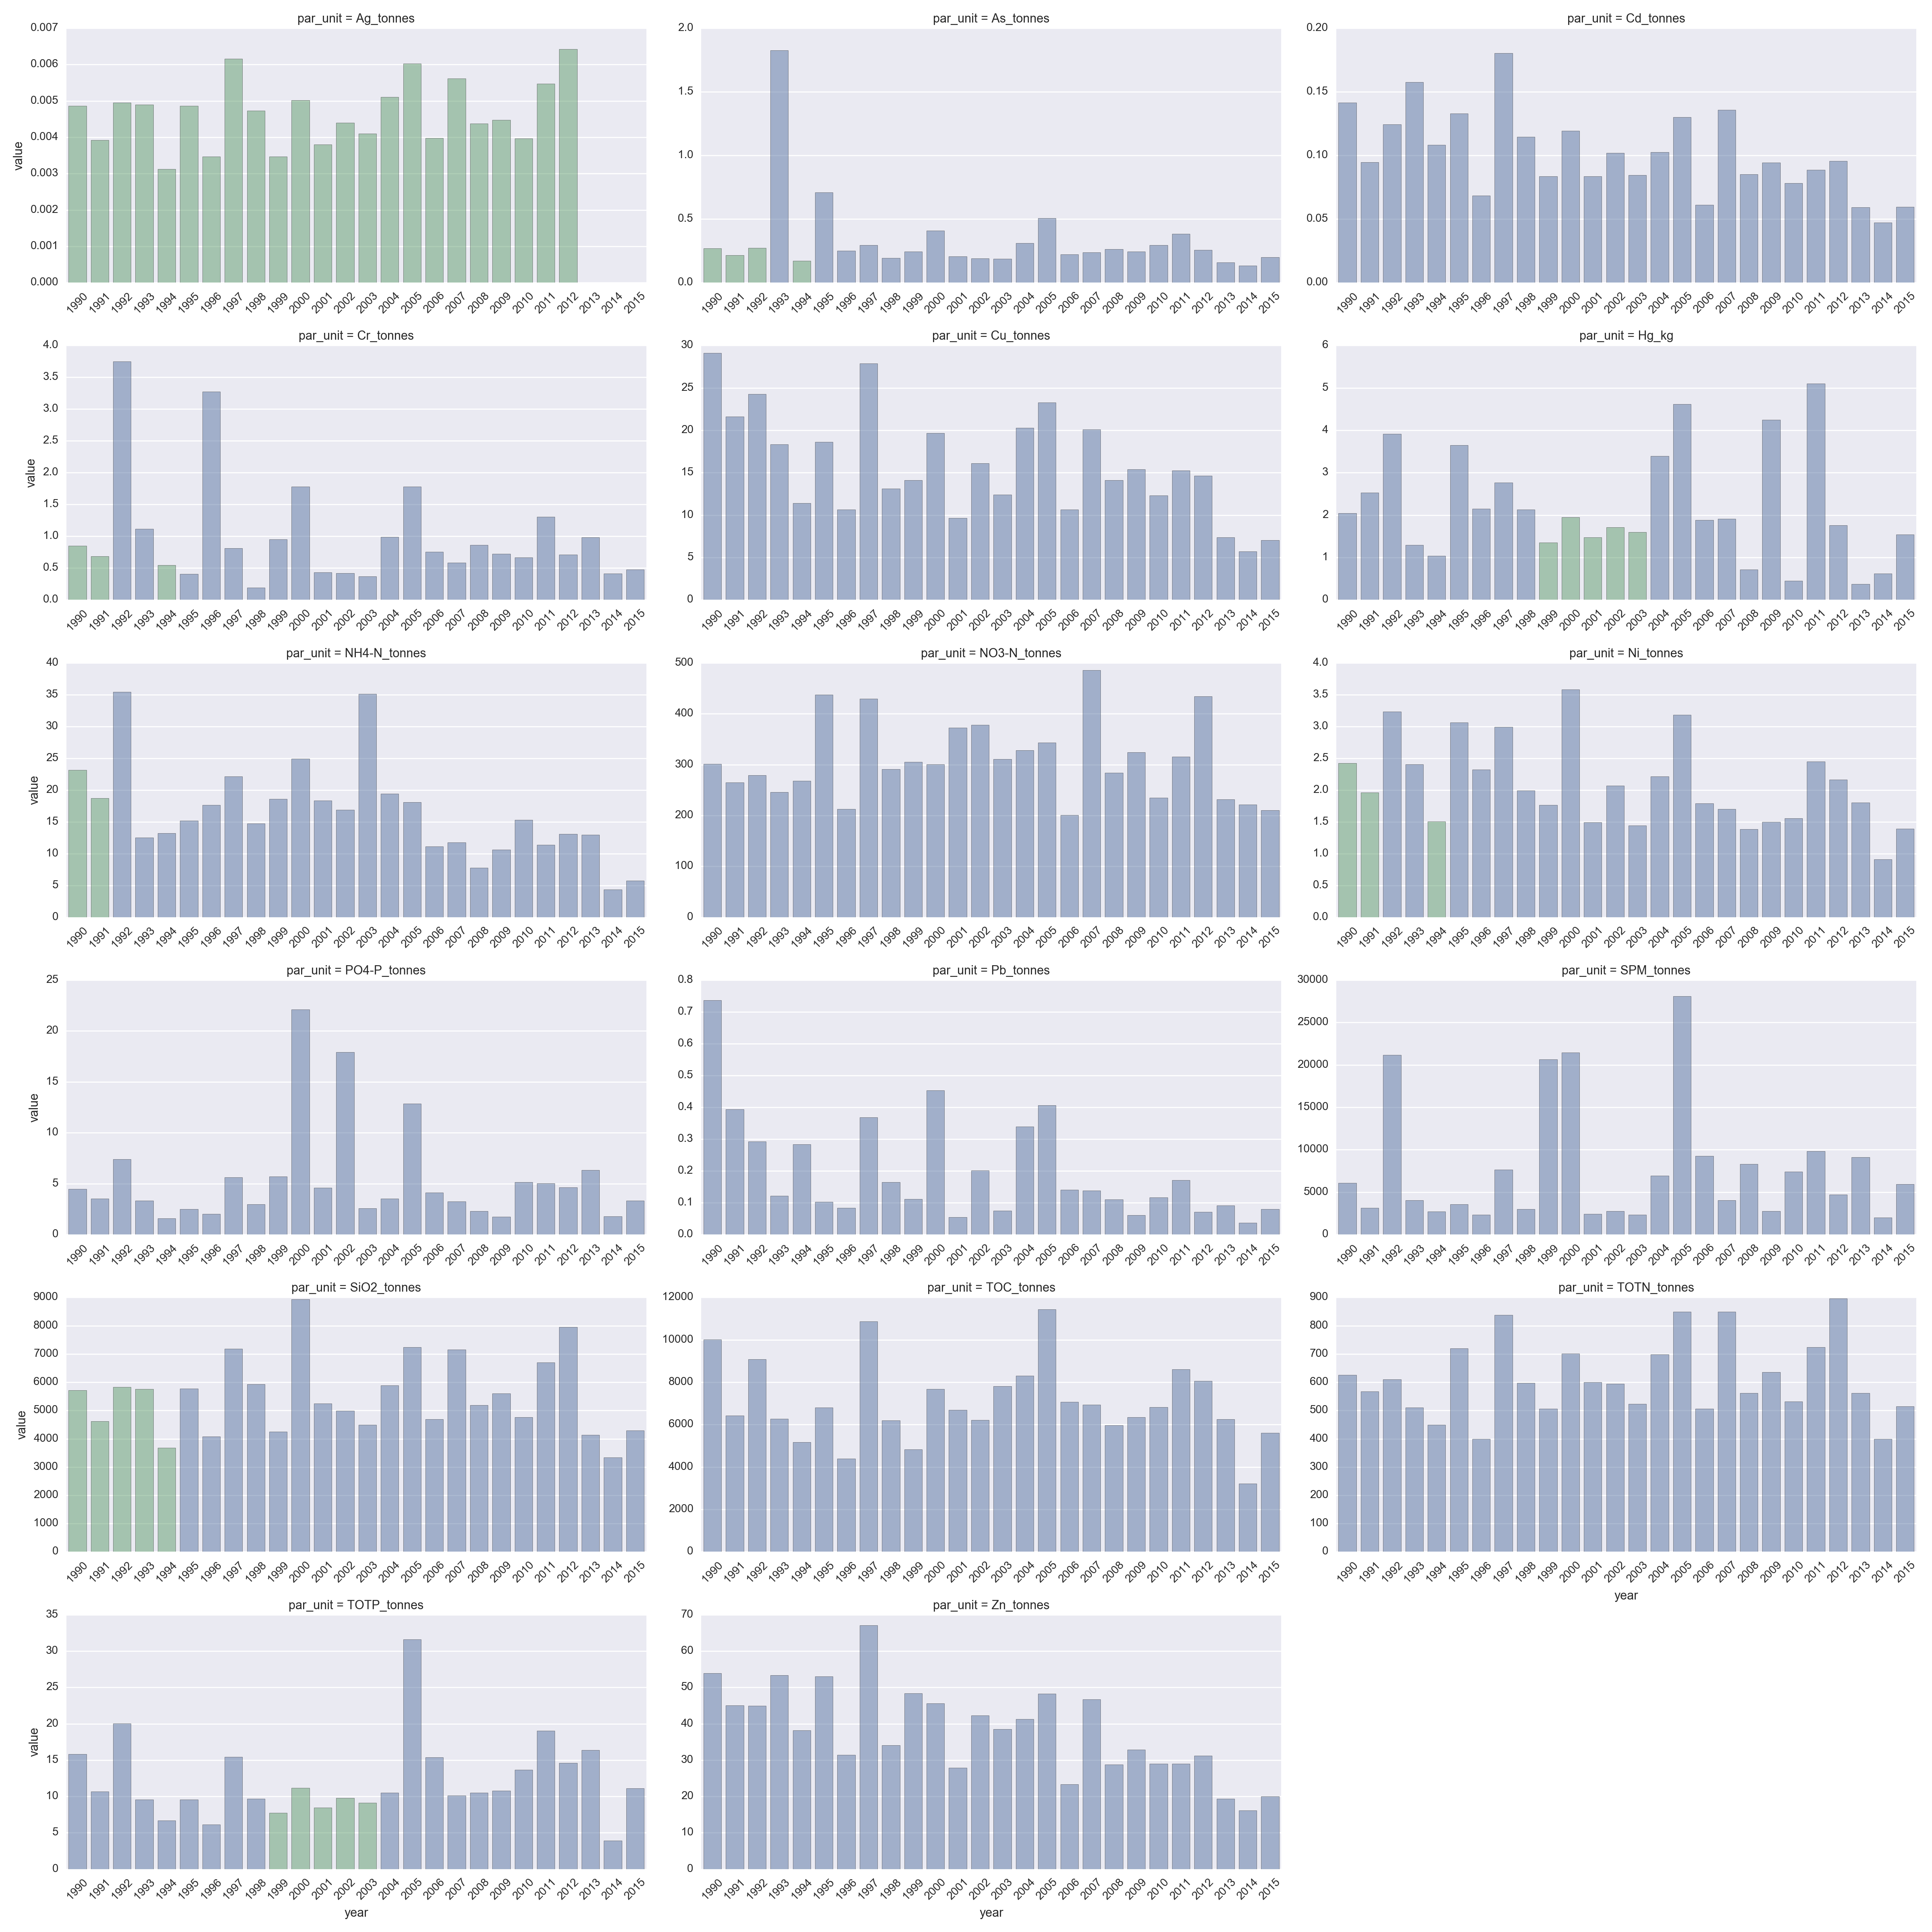

In [12]:
Image(out_path)